This notebook requires four dataframes:
* transposed_df.xlsx
* reduced_dataset_pcav2.xlsx (SC)
* reduced_dataset_CV.xlsx (CV)
* full_results_df.xlsx

Part of the code used in this analysis is adapted from: https://ryan-reilly.medium.com/gridsearch-pipelines-of-multiple-models-on-multiclass-classification-e9124b6ea2e3

In [ ]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



##MACHINE LEARNING USING THE FULL DATASET (df1)

In [ ]:
#Load dataframe
df1 = pd.read_excel('transposed_df.xlsx')

In [ ]:
df1.head()

,Unnamed: 0,dossier_id,911,912,913,914,915,916,917,918,...,2561,2562,2563,2564,2565,2566,2567,2568,2569,faculty
0,0,1152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit Geesteswetenschappen
1,1,1532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit Betawetenschappen
2,2,1649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit der Diergeneeskunde
3,3,1663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2112,D,D,C,D,E,0.4,D,0.6,...,0.142857,0.428571,0.0,0.428571,0.428571,0.428571,0.428571,0.142857,0.142857,Faculteit Geesteswetenschappen


In [ ]:
#List of dossier IDs to drop
dossier_ids_to_drop = [79963, 80245, 81037, 81198, 81740]

#Drop rows with matching dossier IDs
df1 = df1[~df1['dossier_id'].isin(dossier_ids_to_drop)]

In [ ]:
#Drop first two columns
df1 = df1.drop(df1.columns[:2], axis=1)

#Delete row if faculty name is missing
df1 = df1.dropna(subset=['faculty'])

#Delete categorical questions
columns_to_check = [col for col in df1.columns if col != 'faculty']

for col in columns_to_check:
    if not np.issubdtype(df1[col].dtype, np.number):
        df1 = df1.drop(col, axis=1)

#Convert column names to strings
df1.columns = df1.columns.astype(str)

#Delete row if faculty is University College
df1 = df1[~df1['faculty'].str.contains('University College')]

df1.head()

,916,918,919,920,921,922,923,924,925,927,...,2561,2562,2563,2564,2565,2566,2567,2568,2569,faculty
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit Geesteswetenschappen
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit Betawetenschappen
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit der Diergeneeskunde
4,0.4,0.6,0.6,0.4,0.2,0.6,0.6,0.4,0.6,0.6,...,0.142857,0.428571,0.0,0.428571,0.428571,0.428571,0.428571,0.142857,0.142857,Faculteit Geesteswetenschappen
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit Sociale Wetenschappen


In [ ]:
#Change faculty classes to numbers
faculty_mapping = {
    'Faculteit Betawetenschappen': 0,
    'Faculteit Geesteswetenschappen': 1,
    'Faculteit Geneeskunde': 2,
    'Faculteit Geowetenschappen': 3,
    'Faculteit Recht, Economie, Bestuur en Organisatie': 4,
    'Faculteit Sociale Wetenschappen': 5,
    'Faculteit der Diergeneeskunde': 6
}

df1['faculty'] = df1['faculty'].replace(faculty_mapping)


In [ ]:
#Pipeline, Gridsearch, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

#KNN imputation
from sklearn.impute import KNNImputer

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

In [ ]:
#Create a training and testing set and deal with missing values
X = df1.drop(['faculty'], axis=1)
y = df1['faculty']

#Impute missing values using MICE
imputer = IterativeImputer(max_iter=10, random_state=0)
X = imputer.fit_transform(X)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
#Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=19,
                                                    stratify=df1['faculty'])

In [ ]:
#Initiate pipelines
pipe_lr = Pipeline([('LR', LogisticRegression(random_state=19))])
pipe_dt = Pipeline([('DT', DecisionTreeClassifier(random_state=19))])
pipe_rf = Pipeline([('RF', RandomForestClassifier(random_state=19))])
pipe_knn = Pipeline([('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('SVM', svm.SVC(random_state=19))])
pipe_xgb = Pipeline([('XGB', XGBClassifier(random_state=19))])

In [ ]:
#Create pipeline grids
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]
lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': param_range_fl,
                   'LR__solver': ['liblinear']}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]
rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]
knn_param_grid = [{'KNN__n_neighbors': param_range,
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'],
                    'SVM__C': param_range}]
xgb_param_grid = [{'XGB__learning_rate': learning_rates,
                    'XGB__max_depth': param_range,
                    'XGB__min_child_weight': param_range[:2],
                    'XGB__subsample': param_range_fl,
                    'XGB__n_estimators': n_estimators}]

In [ ]:
lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='f1_weighted',
        cv=3)
dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='f1_weighted',
        cv=3)
rf_grid_search = GridSearchCV(estimator=pipe_rf,
        param_grid=rf_param_grid,
        scoring='f1_weighted',
        cv=3)
knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='f1_weighted',
        cv=3)
svm_grid_search = GridSearchCV(estimator=pipe_svm,
        param_grid=svm_param_grid,
        scoring='f1_weighted',
        cv=3)
xgb_grid_search = GridSearchCV(estimator=pipe_xgb,
        param_grid=xgb_param_grid,
        scoring='f1_weighted',
        cv=3)

In [ ]:
grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, svm_grid_search, xgb_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

Logistic Regression Test Weighted F1 score: 0.4064849471090191
Logistic Regression Best Params: {'LR__C': 1.0, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}


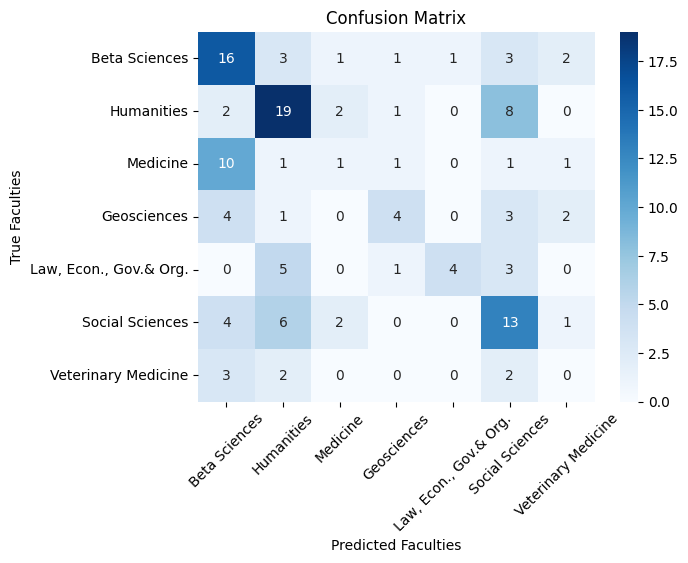

Decision Trees Test Weighted F1 score: 0.25310520113992013
Decision Trees Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 4, 'DT__min_samples_leaf': 6, 'DT__min_samples_split': 2}


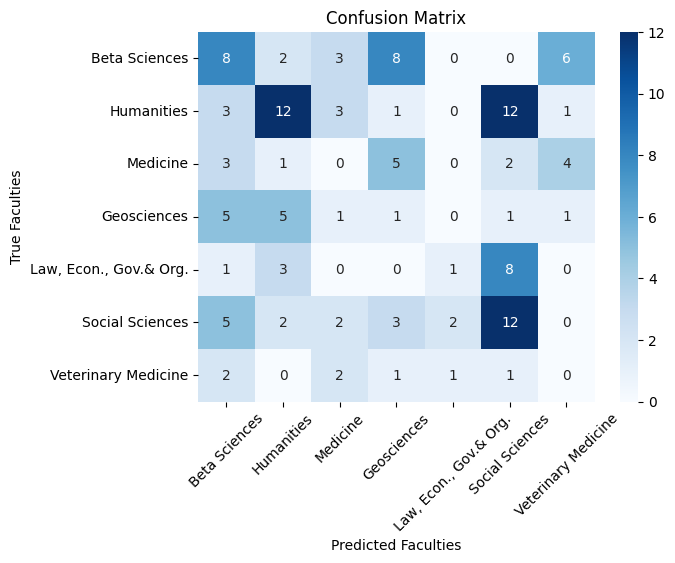

Random Forest Test Weighted F1 score: 0.30772443980508857
Random Forest Best Params: {'RF__max_depth': 6, 'RF__min_samples_leaf': 4, 'RF__min_samples_split': 2}


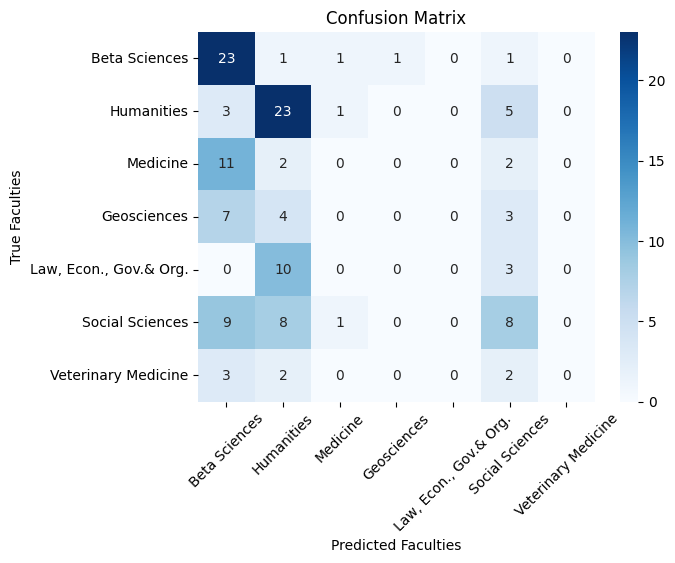

K-Nearest Neighbors Test Weighted F1 score: 0.31044222169776736
K-Nearest Neighbors Best Params: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 6, 'KNN__weights': 'distance'}


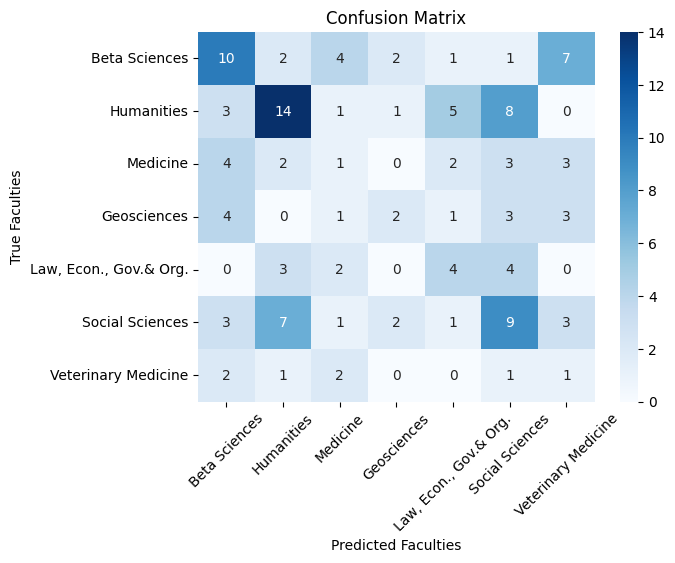

Support Vector Machines Test Weighted F1 score: 0.39375963345040255
Support Vector Machines Best Params: {'SVM__C': 5, 'SVM__kernel': 'rbf'}


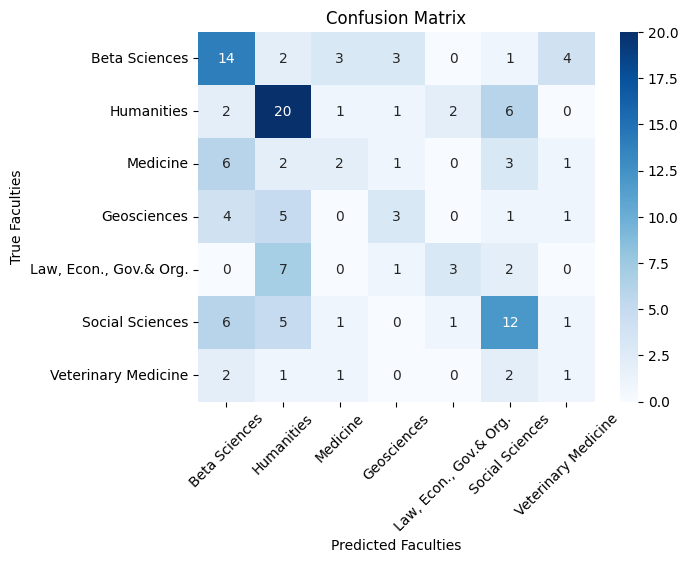

XGBoost Test Weighted F1 score: 0.345622993130233
XGBoost Best Params: {'XGB__learning_rate': 0.3, 'XGB__max_depth': 1, 'XGB__min_child_weight': 2, 'XGB__n_estimators': 150, 'XGB__subsample': 1.0}


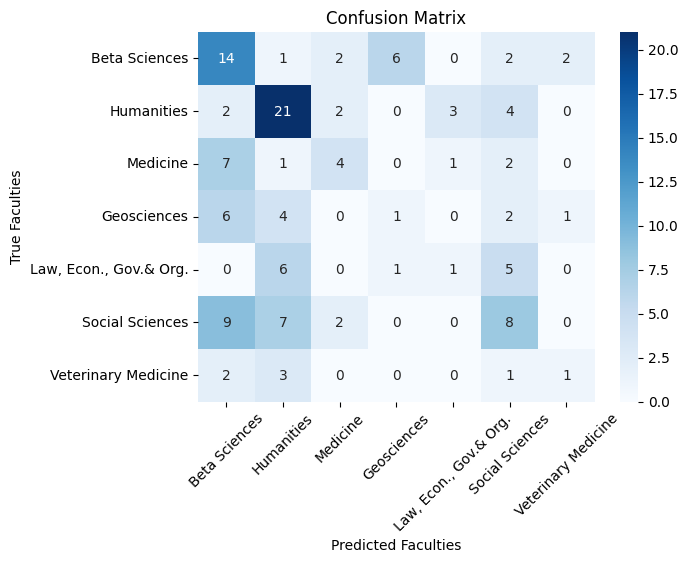

In [ ]:
#Initiate pipelines for all models
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees',
             2: 'Random Forest', 3: 'K-Nearest Neighbors',
             4: 'Support Vector Machines', 5: 'XGBoost'}

#Print weighted f1 score for each best scoring model
for i, model in enumerate(grids):
    print('{} Test Weighted F1 score: {}'.format(grid_dict[i],
    model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(grid_dict[i],          model.best_params_))

    #Create confusion matrix
    y_pred = model.predict(X_test)
    y_true = y_test
    class_labels = ['Beta Sciences',
    'Humanities',
    'Medicine',
    'Geosciences',
    'Law, Econ., Gov.& Org.',
    'Social Sciences',
    'Veterinary Medicine']
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
    ax.set_xlabel('Predicted Faculties')
    ax.set_ylabel('True Faculties')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

##MACHINE LEARNING USING THE REDUCED DATASET FROM PCA V1(df2)

In [ ]:
#Load dataframe
df2 = pd.read_excel('reduced_dataset_pcaCV.xlsx')
df2.head()

In [ ]:
#Transpose df2
#Select the columns you want to keep
columns_to_keep = ['question_id', 'dossier_id', 'answer']

#Pivot the dataframe
transposed_df = df2.pivot(index='dossier_id', columns='question_id', values='answer')

#Reset the index
transposed_df.reset_index(inplace=True)

#Merge the transposed dataframe with the original dataframe to add 'faculty'
transposed_df = transposed_df.merge(df2[['dossier_id', 'faculty']].drop_duplicates(), on='dossier_id', how='left')

#Check transposed df
print(transposed_df)
df2 = transposed_df

In [ ]:
#List of dossier IDs to drop
dossier_ids_to_drop = [79963, 80245, 81037, 81198, 81740]

#Drop rows with matching dossier IDs
df2 = df2[~df2['dossier_id'].isin(dossier_ids_to_drop)]

In [ ]:
#Drop first column
df2 = df2.drop(df2.columns[:1], axis=1)

#Delete row if faculty name is missing
df2 = df2.dropna(subset=['faculty'])

#Delete categorical questions
columns_to_delete = []

for column in df2.columns:
    if column != 'faculty':
        if df2[column].dtype == object:
            if df2[column].str.match(r'^[A-F]$').any():
                columns_to_delete.append(column)

df2 = df2.drop(columns=columns_to_delete)

#Convert column names to strings
df2.columns = df2.columns.astype(str)

#Delete row if faculty is University College
df2 = df2[~df2['faculty'].str.contains('University College')]


In [ ]:
#Change faculty classes to numbers
faculty_mapping = {
    'Faculteit Betawetenschappen': 0,
    'Faculteit Geesteswetenschappen': 1,
    'Faculteit Geneeskunde': 2,
    'Faculteit Geowetenschappen': 3,
    'Faculteit Recht, Economie, Bestuur en Organisatie': 4,
    'Faculteit Sociale Wetenschappen': 5,
    'Faculteit der Diergeneeskunde': 6
}

df2['faculty'] = df2['faculty'].replace(faculty_mapping)


In [ ]:
#Create a training and testing set and deal with missing values
X = df2.drop(['faculty'], axis=1)
y = df2['faculty']

#Impute missing values using MICE
imputer = IterativeImputer(max_iter=10, random_state=0)
X = imputer.fit_transform(X)

#Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=19,
                                                    stratify=df2['faculty'])

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
#Check length
len(X_train)

534

In [ ]:
grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, svm_grid_search, xgb_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

Logistic Regression Test Weighted F1 score: 0.39359521075938986
Logistic Regression Best Params: {'LR__C': 1.0, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}


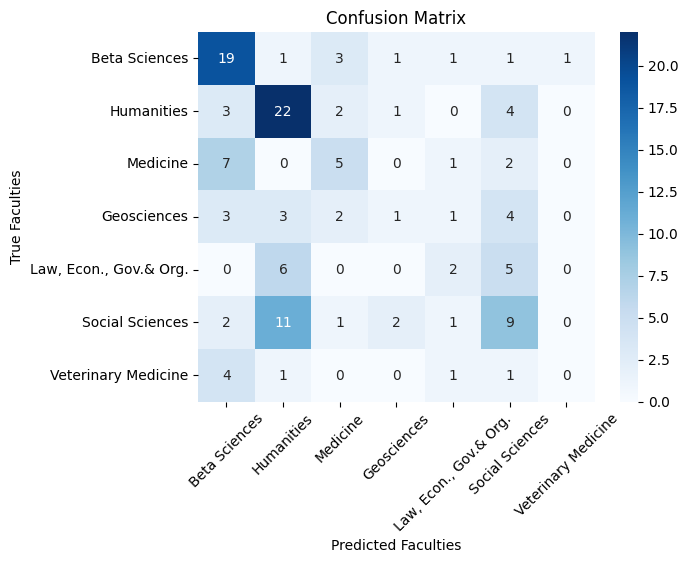

Decision Trees Test Weighted F1 score: 0.30527149063024156
Decision Trees Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 4, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}


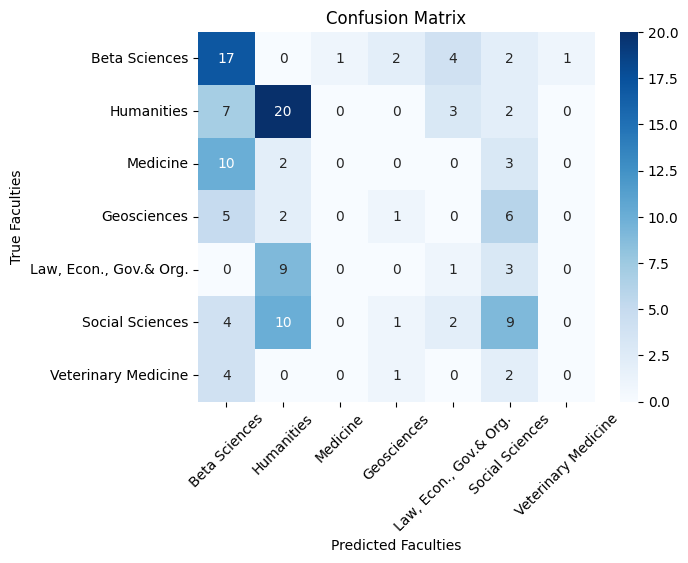

Random Forest Test Weighted F1 score: 0.30215678176778826
Random Forest Best Params: {'RF__max_depth': 6, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 4}


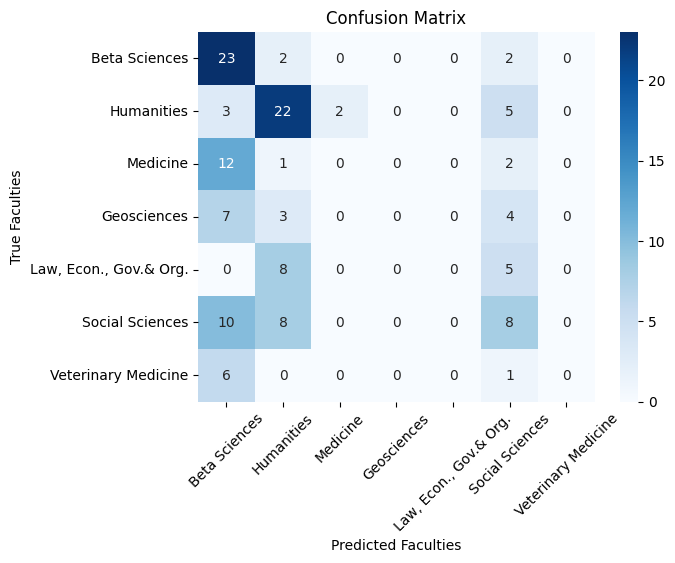

K-Nearest Neighbors Test Weighted F1 score: 0.3028538001447428
K-Nearest Neighbors Best Params: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 6, 'KNN__weights': 'uniform'}


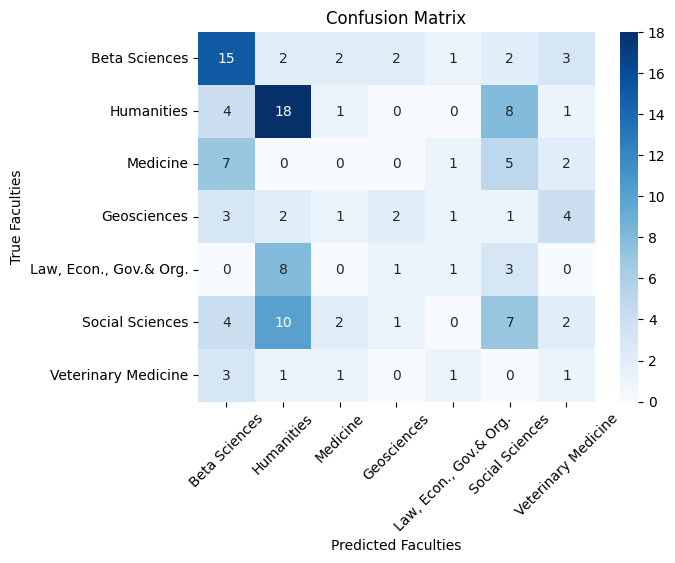

Support Vector Machines Test Weighted F1 score: 0.3421711301863616
Support Vector Machines Best Params: {'SVM__C': 5, 'SVM__kernel': 'rbf'}


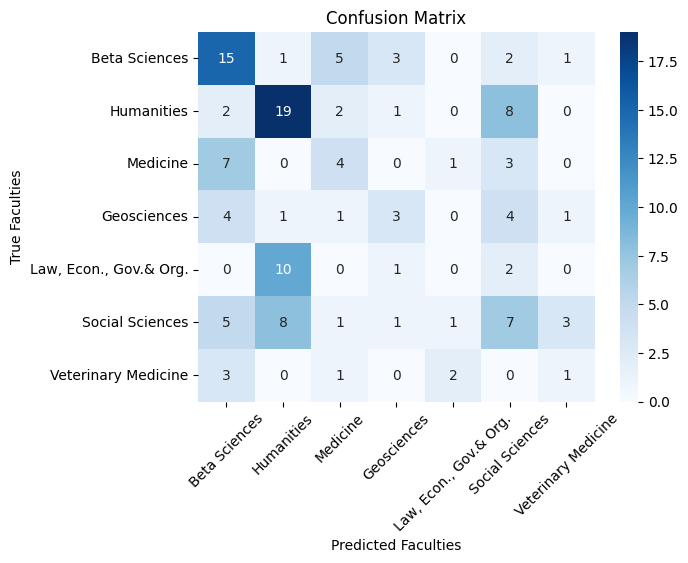

XGBoost Test Weighted F1 score: 0.31359155547559786
XGBoost Best Params: {'XGB__learning_rate': 0.2, 'XGB__max_depth': 2, 'XGB__min_child_weight': 2, 'XGB__n_estimators': 100, 'XGB__subsample': 1.0}


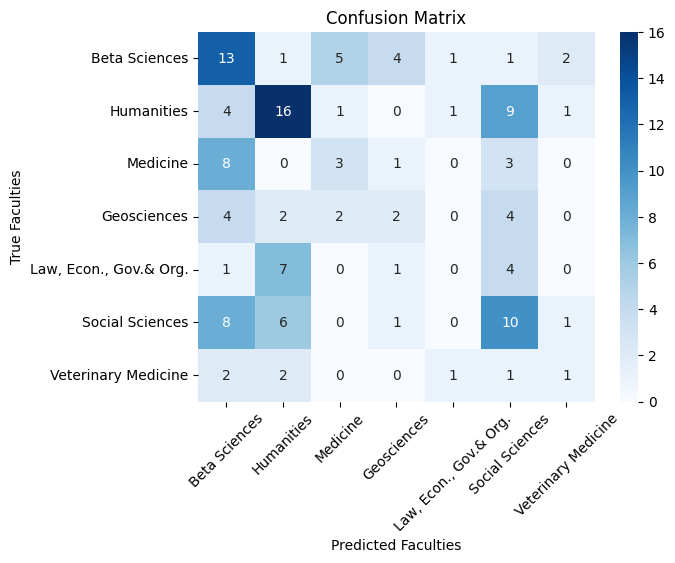

In [ ]:
#Initiate pipelines for all models
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees',
             2: 'Random Forest', 3: 'K-Nearest Neighbors',
             4: 'Support Vector Machines', 5: 'XGBoost'}

#Print weighted f1 score for each best scoring model
for i, model in enumerate(grids):
    print('{} Test Weighted F1 score: {}'.format(grid_dict[i],
    model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(grid_dict[i],          model.best_params_))

    #Create confusion matrix
    y_pred = model.predict(X_test)
    y_true = y_test
    class_labels = ['Beta Sciences',
    'Humanities',
    'Medicine',
    'Geosciences',
    'Law, Econ., Gov.& Org.',
    'Social Sciences',
    'Veterinary Medicine']
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
    ax.set_xlabel('Predicted Faculties')
    ax.set_ylabel('True Faculties')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

##MACHINE LEARNING USING THE REDUCED DATASET FROM PCA V2(df3)

In [ ]:
#Load dataframe
df3 = pd.read_excel('reduced_dataset_pcav2.xlsx')
df3.head()

,question_id,dossier_id,answer,answeredTest_id,question,type,label,datetime,maingroup,maingroup_id,level1subgroup1,faculty
0,2269,1152,0.6,19833,question.id_2269,likert/likert5puntsacceptatie2positiefpluseen,je gevoelens duidelijk uiten,2022-06-27 12:36:27,Beroepskeuzetest,459.0,Sociaal,Faculteit Geesteswetenschappen
1,2278,1152,0.6,19833,question.id_2278,likert/likert5puntsacceptatie2positiefpluseen,activiteiten en evenementen organiseren,2022-06-27 12:36:27,Beroepskeuzetest,459.0,Ondernemend,Faculteit Geesteswetenschappen
2,2283,1152,0.6,19833,question.id_2283,likert/likert5puntsacceptatie2positiefpluseen,goed overweg met een computer,2022-06-27 12:36:27,Beroepskeuzetest,459.0,Conventioneel,Faculteit Geesteswetenschappen
3,2279,1152,0.4,19833,question.id_2279,likert/likert5puntsacceptatie2positiefpluseen,een groepsgesprek leiden,2022-06-27 12:36:27,Beroepskeuzetest,459.0,Ondernemend,Faculteit Geesteswetenschappen
4,2250,1152,0.2,19833,question.id_2250,likert/likert5puntsacceptatie2positiefpluseen,elektrische dingen fixen,2022-06-27 12:36:27,Beroepskeuzetest,459.0,Realistisch,Faculteit Geesteswetenschappen


In [ ]:
#Transpose df3
#Select the columns you want to keep
columns_to_keep = ['question_id', 'dossier_id', 'answer']

#Pivot the dataframe
transposed_df = df3.pivot(index='dossier_id', columns='question_id', values='answer')

#Reset the index
transposed_df.reset_index(inplace=True)

#Merge the transposed dataframe with the original dataframe to add 'faculty'
transposed_df = transposed_df.merge(df3[['dossier_id', 'faculty']].drop_duplicates(), on='dossier_id', how='left')

# Display the transposed dataframe
print(transposed_df)
df3 = transposed_df

     dossier_id  913  919  920  921  922  923  924  932  948  ...  \
0          1152  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1          1532  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2          1649  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
3          1663  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
4          2112    C  0.6  0.4  0.2  0.6  0.6  0.4    D  NaN  ...   
..          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
745       91894    B  0.6  0.4  0.2  0.2  0.2  0.8    A  NaN  ...   
746       91908  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
747       91927  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
748       91928    C  0.6  0.6  0.4  0.6  0.6  0.4    D  NaN  ...   
749       91930  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   

                  2538               2542               2553  \
0                  NaN                NaN                NaN   
1                  NaN                NaN  

In [ ]:
#List of dossier IDs to drop
dossier_ids_to_drop = [79963, 80245, 81037, 81198, 81740]

#Drop rows with matching dossier IDs
df3 = df3[~df3['dossier_id'].isin(dossier_ids_to_drop)]

In [ ]:
#Drop first column
df3 = df3.drop(df3.columns[:1], axis=1)

#Delete row if faculty name is missing
df3 = df3.dropna(subset=['faculty'])

#Delete categorical questions
columns_to_delete = []

for column in df3.columns:
    if column != 'faculty':
        if df3[column].dtype == object:
            if df3[column].str.match(r'^[A-F]$').any():
                columns_to_delete.append(column)

df3 = df3.drop(columns=columns_to_delete)

#Convert column names to strings
df3.columns = df3.columns.astype(str)

#Delete row if faculty is University College
df3 = df3[~df3['faculty'].str.contains('University College')]

In [ ]:
df3

,919,920,921,922,923,924,948,949,951,952,...,2538,2542,2553,2555,2556,2558,2559,2560,2561,faculty
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit Geesteswetenschappen
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit Betawetenschappen
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit der Diergeneeskunde
4,0.6,0.4,0.2,0.6,0.6,0.4,NaN,NaN,NaN,NaN,...,0.428571428571429,0.714285714285714,0.285714285714286,0,0,0.142857142857143,0,0.428571428571429,0.142857142857143,Faculteit Geesteswetenschappen
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit Sociale Wetenschappen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.6,0.4,0.2,0.2,0.2,0.8,NaN,NaN,NaN,NaN,...,0.428571428571429,0.714285714285714,0.428571428571429,0.142857142857143,0.428571428571429,0.571428571428571,0.571428571428571,0.571428571428571,0.142857142857143,Faculteit Sociale Wetenschappen
746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.428571428571429,0.571428571428571,0.142857142857143,0.285714285714286,0,0.428571428571429,0.285714285714286,0.142857142857143,0.142857142857143,Faculteit Geesteswetenschappen
747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.428571428571429,0.428571428571429,0.142857142857143,0,0,0.142857142857143,0.142857142857143,0,0,Faculteit Geowetenschappen
748,0.6,0.6,0.4,0.6,0.6,0.4,NaN,NaN,NaN,NaN,...,0.571428571428571,0.714285714285714,0.714285714285714,0.571428571428571,0.714285714285714,0.428571428571429,0.571428571428571,0.571428571428571,0.714285714285714,"Faculteit Recht, Economie, Bestuur en Organisatie"


In [ ]:
#Change faculty classes to numbers
faculty_mapping = {
    'Faculteit Betawetenschappen': 0,
    'Faculteit Geesteswetenschappen': 1,
    'Faculteit Geneeskunde': 2,
    'Faculteit Geowetenschappen': 3,
    'Faculteit Recht, Economie, Bestuur en Organisatie': 4,
    'Faculteit Sociale Wetenschappen': 5,
    'Faculteit der Diergeneeskunde': 6
}

df3['faculty'] = df3['faculty'].replace(faculty_mapping)

In [ ]:
#Create a training and testing set and deal with missing values
X = df3.drop(['faculty'], axis=1)
y = df3['faculty']

#Impute missing values using MICE
imputer = IterativeImputer(max_iter=10, random_state=0)
X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=19,
                                                    stratify=df3['faculty'])

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, svm_grid_search, xgb_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

Logistic Regression Test Weighted F1 score: 0.34445402528749947
Logistic Regression Best Params: {'LR__C': 1.0, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}


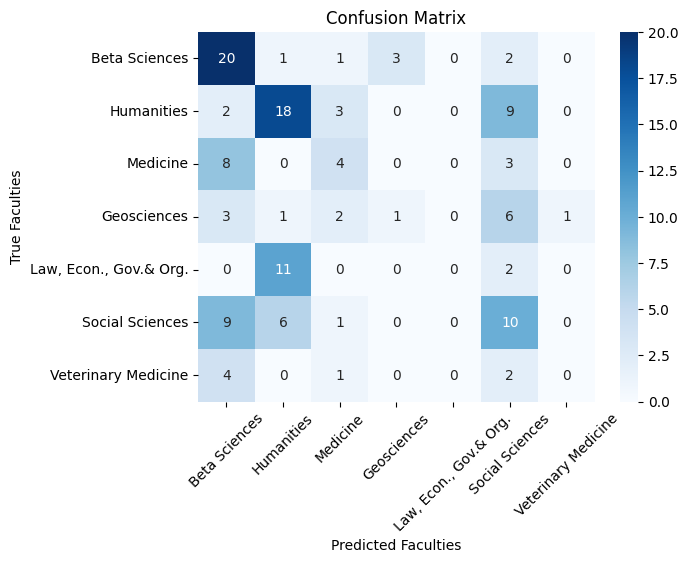

Decision Trees Test Weighted F1 score: 0.19952077138485524
Decision Trees Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 5, 'DT__min_samples_leaf': 5, 'DT__min_samples_split': 2}


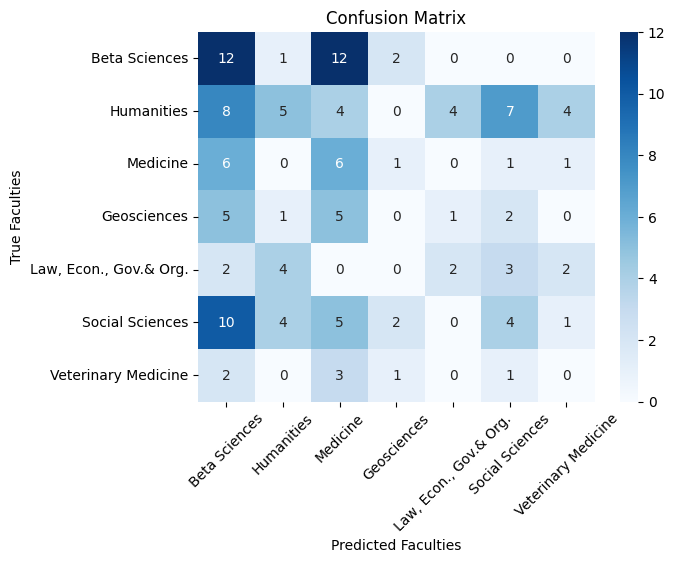

Random Forest Test Weighted F1 score: 0.2814969189931431
Random Forest Best Params: {'RF__max_depth': 5, 'RF__min_samples_leaf': 5, 'RF__min_samples_split': 2}


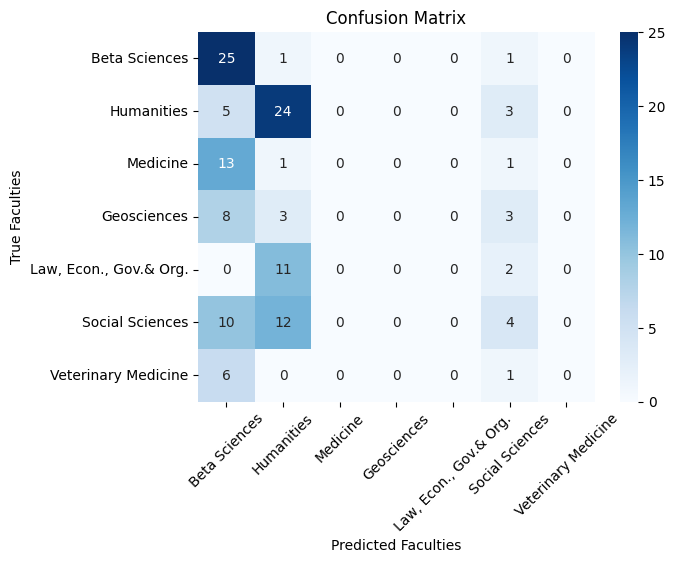

K-Nearest Neighbors Test Weighted F1 score: 0.24262568436357027
K-Nearest Neighbors Best Params: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3, 'KNN__weights': 'uniform'}


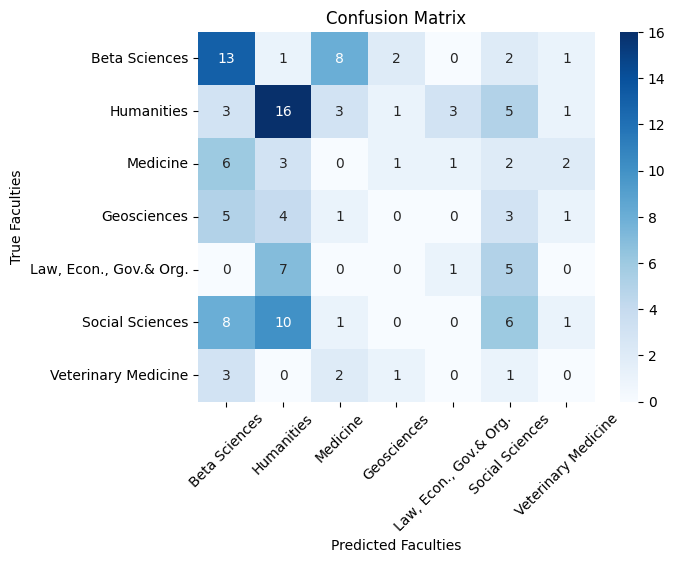

Support Vector Machines Test Weighted F1 score: 0.3131748233147675
Support Vector Machines Best Params: {'SVM__C': 6, 'SVM__kernel': 'rbf'}


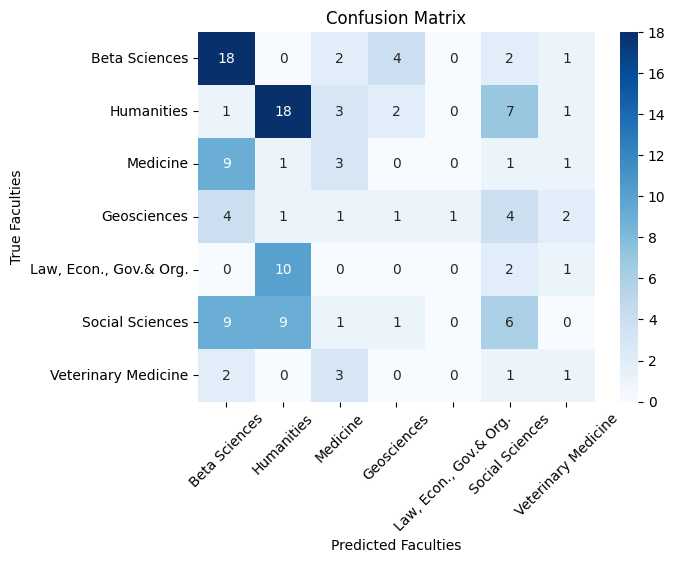

XGBoost Test Weighted F1 score: 0.31212206728010067
XGBoost Best Params: {'XGB__learning_rate': 0.3, 'XGB__max_depth': 4, 'XGB__min_child_weight': 1, 'XGB__n_estimators': 100, 'XGB__subsample': 1.0}


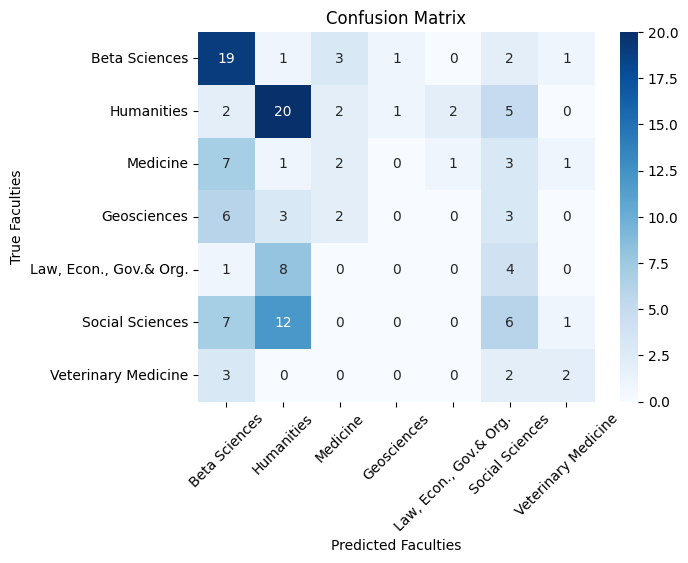

In [ ]:
#Initiate pipelines for all models
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees',
             2: 'Random Forest', 3: 'K-Nearest Neighbors',
             4: 'Support Vector Machines', 5: 'XGBoost'}

#Print weighted f1 score for each best scoring model
for i, model in enumerate(grids):
    print('{} Test Weighted F1 score: {}'.format(grid_dict[i],
    model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(grid_dict[i],          model.best_params_))

    #Create confusion matrix
    y_pred = model.predict(X_test)
    y_true = y_test
    class_labels = ['Beta Sciences',
    'Humanities',
    'Medicine',
    'Geosciences',
    'Law, Econ., Gov.& Org.',
    'Social Sciences',
    'Veterinary Medicine']
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
    ax.set_xlabel('Predicted Faculties')
    ax.set_ylabel('True Faculties')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

##MACHINE LEARNING USING ONLY THE FINAL TEST SCORES(df4)

In [ ]:
#Load dataframe
df4 = pd.read_excel('full_results_df.xlsx')
df4.head()

,Unnamed: 0,content,process,socialskills,complexproblemsolving,technicalskills,systemskills,resourcemanagementskills,dossier_id,competences,...,Intellectueel,pers_trait,Prestaties leveren,Arbeidsvoorwaarden,Erkenning,Collegialiteit,Ondersteuning,Onafhankelijkheid_wv,workvalue,faculty
0,0,8.881784e-16,1.000000,5.000000e-01,0.000000,-2.666667e+00,-0.500000,0.000000e+00,2112,process,...,0.00,Ondernemend,0.4,-2.000000e+00,-0.1,0.1,-0.7,0.3,Prestaties leveren,Faculteit Geesteswetenschappen
1,1,3.333333e-01,-0.500000,-5.000000e-01,-0.166667,-5.000000e-01,-0.166667,-5.551115e-17,42916,content,...,3.75,Realistisch,0.6,1.000000e+00,-0.1,0.7,0.9,0.5,Arbeidsvoorwaarden,Faculteit der Diergeneeskunde
2,2,8.333333e-01,0.333333,-1.110223e-16,-0.166667,-1.666667e-01,-0.333333,-5.000000e-01,47861,content,...,3.00,Realistisch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit Geowetenschappen
3,3,3.333333e-01,0.666667,1.166667e+00,0.166667,-1.054712e-15,0.166667,1.166667e+00,50367,socialskills,...,4.75,Intellectueel,0.2,1.110223e-16,0.3,0.7,0.5,0.1,Collegialiteit,Faculteit Geowetenschappen
4,4,1.666667e-01,1.000000,-1.000000e+00,0.166667,-1.500000e+00,-0.500000,-1.000000e+00,55937,process,...,5.50,Realistisch,0.4,-1.600000e+00,-1.3,0.3,0.5,-0.3,Ondersteuning,Faculteit der Diergeneeskunde


In [ ]:
#Drop first column
df4 = df4.drop(df4.columns[:1], axis=1)

df4 = df4.drop('dossier_id', axis=1)

#Delete row if faculty name is missing
df4 = df4.dropna(subset=['faculty'])

#Delete categorical questions
columns_to_check = [col for col in df4.columns if col != 'faculty']

for col in columns_to_check:
    if not np.issubdtype(df4[col].dtype, np.number):
        df4 = df4.drop(col, axis=1)

#Convert column names to strings
df4.columns = df4.columns.astype(str)

#Delete row if faculty is University College
df4['faculty'] = df4['faculty'].astype(str)
df4 = df4[~df4['faculty'].str.contains('University College')]

In [ ]:
df4

,content,process,socialskills,complexproblemsolving,technicalskills,systemskills,resourcemanagementskills,Gerichtheid op mensen,Sociale invloed,Aanpassingsvermogen,...,Ondernemend,Realistisch,Intellectueel,Prestaties leveren,Arbeidsvoorwaarden,Erkenning,Collegialiteit,Ondersteuning,Onafhankelijkheid_wv,faculty
0,8.881784e-16,1.000000,5.000000e-01,0.000000,-2.666667e+00,-0.500000,0.000000e+00,1.1,0.3,0.1,...,7.25,0.25,0.00,0.4,-2.000000e+00,-0.1,0.1,-0.7,0.3,Faculteit Geesteswetenschappen
1,3.333333e-01,-0.500000,-5.000000e-01,-0.166667,-5.000000e-01,-0.166667,-5.551115e-17,0.7,-0.1,-0.1,...,0.50,4.50,3.75,0.6,1.000000e+00,-0.1,0.7,0.9,0.5,Faculteit der Diergeneeskunde
2,8.333333e-01,0.333333,-1.110223e-16,-0.166667,-1.666667e-01,-0.333333,-5.000000e-01,0.7,-0.1,0.3,...,0.75,4.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,Faculteit Geowetenschappen
3,3.333333e-01,0.666667,1.166667e+00,0.166667,-1.054712e-15,0.166667,1.166667e+00,0.7,0.1,1.1,...,1.75,2.25,4.75,0.2,1.110223e-16,0.3,0.7,0.5,0.1,Faculteit Geowetenschappen
4,1.666667e-01,1.000000,-1.000000e+00,0.166667,-1.500000e+00,-0.500000,-1.000000e+00,0.5,0.3,-0.3,...,0.00,7.50,5.50,0.4,-1.600000e+00,-1.3,0.3,0.5,-0.3,Faculteit der Diergeneeskunde
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.4,-2.000000e+00,-0.3,0.3,-0.1,-0.3,Faculteit Sociale Wetenschappen
806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.2,-1.400000e+00,-1.1,-0.3,0.3,0.3,Faculteit Geneeskunde
807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.2,-1.400000e+00,-0.5,-0.3,0.5,-0.5,Faculteit Betawetenschappen
808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.4,-6.000000e-01,-1.3,0.3,0.1,-0.9,Faculteit Betawetenschappen


In [ ]:
#Change faculty classes to numbers
faculty_mapping = {
    'Faculteit Betawetenschappen': 0,
    'Faculteit Geesteswetenschappen': 1,
    'Faculteit Geneeskunde': 2,
    'Faculteit Geowetenschappen': 3,
    'Faculteit Recht, Economie, Bestuur en Organisatie': 4,
    'Faculteit Sociale Wetenschappen': 5,
    'Faculteit der Diergeneeskunde': 6
}

df4['faculty'] = df4['faculty'].replace(faculty_mapping)

In [ ]:
#Create a training and testing set and deal with missing values
X = df4.drop(['faculty'], axis=1)
y = df4['faculty']

#Impute missing values using MICE
imputer = IterativeImputer(max_iter=10, random_state=0)
X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=19,
                                                    stratify=df4['faculty'])



/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Logistic Regression Test Weighted F1 score: 0.33840327821760546
Logistic Regression Best Params: {'LR__C': 0.5, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}


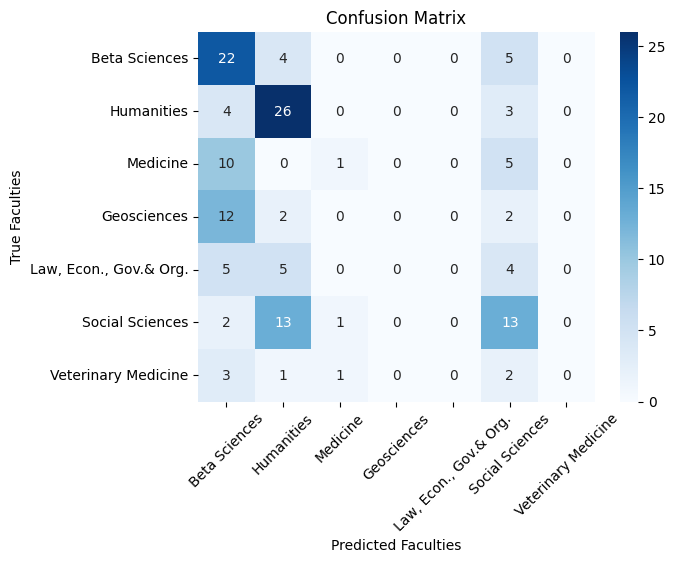

In [ ]:
#Get results of best scoring parameters and create confusion matrix
lr_grid_search.fit(X_train, y_train)

print('Logistic Regression Test Weighted F1 score: {}'.format(lr_grid_search.score(X_test, y_test)))
print('Logistic Regression Best Params: {}'.format(lr_grid_search.best_params_))
y_pred = lr_grid_search.predict(X_test)
y_true = y_test
class_labels = ['Beta Sciences',
    'Humanities',
    'Medicine',
    'Geosciences',
    'Law, Econ., Gov.& Org.',
    'Social Sciences',
    'Veterinary Medicine']
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
ax.set_xlabel('Predicted Faculties')
ax.set_ylabel('True Faculties')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

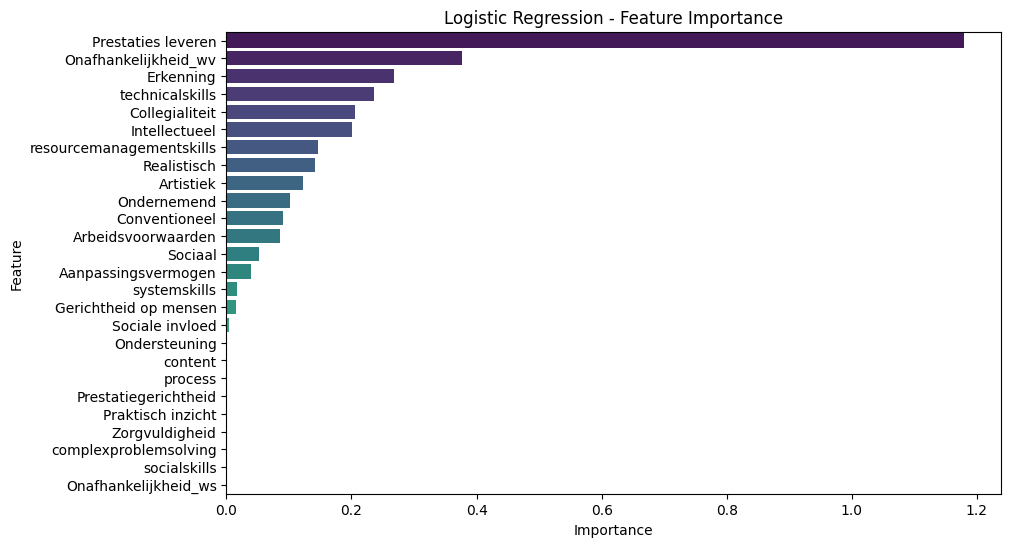

                     Feature  Importance
20        Prestaties leveren    1.180160
25      Onafhankelijkheid_wv    0.377379
22                 Erkenning    0.268070
4            technicalskills    0.235603
23            Collegialiteit    0.206196
19             Intellectueel    0.200333
6   resourcemanagementskills    0.146943
18               Realistisch    0.141488
15                 Artistiek    0.122949
17               Ondernemend    0.101112
14             Conventioneel    0.090389
21        Arbeidsvoorwaarden    0.085215
16                   Sociaal    0.052429
9        Aanpassingsvermogen    0.038533
5               systemskills    0.017138
7      Gerichtheid op mensen    0.014606
8            Sociale invloed    0.004306
24             Ondersteuning    0.000000
0                    content    0.000000
1                    process    0.000000
12      Prestatiegerichtheid    0.000000
11         Praktisch inzicht    0.000000
10            Zorgvuldigheid    0.000000
3      complexpr

In [ ]:
#Feature importance analysis

#Fit the logistic regression model
lr_model = lr_grid_search.best_estimator_.named_steps['LR']
lr_model.fit(X_train, y_train)

#Get feature importances
feature_importances = lr_model.coef_[0]

#Create a dataframe with feature names and importances
importance_df = pd.DataFrame({'Feature': df4.drop('faculty', axis=1).columns, 'Importance': np.abs(feature_importances)})
importance_df.sort_values('Importance', ascending=False, inplace=True)

#Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Logistic Regression - Feature Importance')
plt.show()

#Display the importance dataframe as a table
print(importance_df)

In [ ]:
#Save results for visualization purposes
importance_df.to_excel('feature_importance.xlsx', index=True)

Decision Trees Test Weighted F1 score: 0.27651299468332435
Decision Trees Best Params: {'DT__criterion': 'entropy', 'DT__max_depth': 6, 'DT__min_samples_leaf': 4, 'DT__min_samples_split': 2}


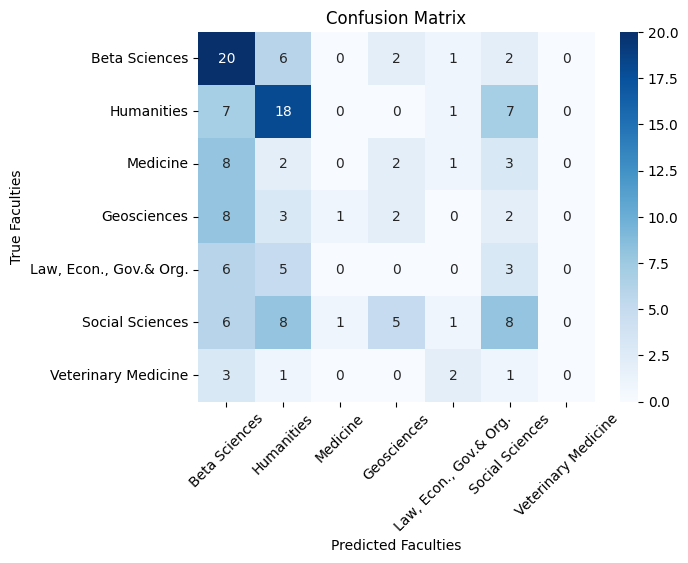

In [ ]:
#Get results of best scoring parameters and create confusion matrix
dt_grid_search.fit(X_train, y_train)

print('Decision Trees Test Weighted F1 score: {}'.format(dt_grid_search.score(X_test, y_test)))
print('Decision Trees Best Params: {}'.format(dt_grid_search.best_params_))
y_pred = dt_grid_search.predict(X_test)
y_true = y_test
class_labels = ['Beta Sciences',
    'Humanities',
    'Medicine',
    'Geosciences',
    'Law, Econ., Gov.& Org.',
    'Social Sciences',
    'Veterinary Medicine']
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
ax.set_xlabel('Predicted Faculties')
ax.set_ylabel('True Faculties')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Random Forest Test Weighted F1 score: 0.3063437703848663
Random Forest Best Params: {'RF__max_depth': 6, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 6}


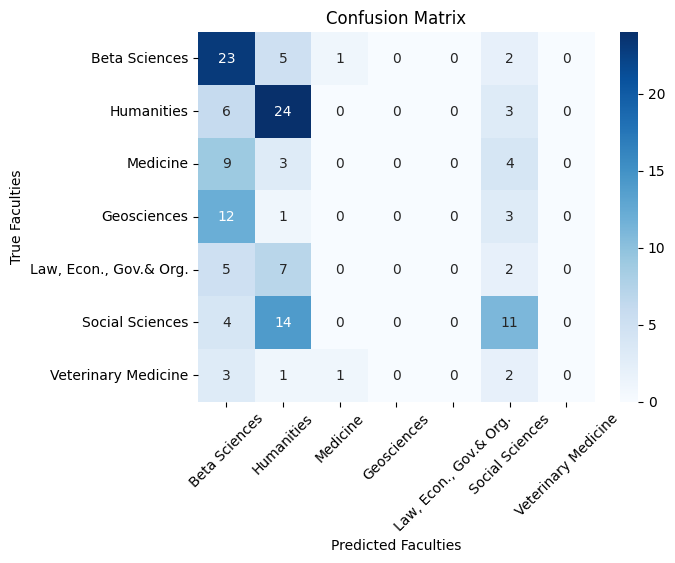

In [ ]:
#Get results of best scoring parameters and create confusion matrix
rf_grid_search.fit(X_train, y_train)

print('Random Forest Test Weighted F1 score: {}'.format(rf_grid_search.score(X_test, y_test)))
print('Random Forest Best Params: {}'.format(rf_grid_search.best_params_))
y_pred = rf_grid_search.predict(X_test)
y_true = y_test
class_labels = ['Beta Sciences',
    'Humanities',
    'Medicine',
    'Geosciences',
    'Law, Econ., Gov.& Org.',
    'Social Sciences',
    'Veterinary Medicine']
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
ax.set_xlabel('Predicted Faculties')
ax.set_ylabel('True Faculties')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

K-Nearest Neighbors Test Weighted F1 score: 0.23403132497484716
K-Nearest Neighbors Best Params: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 4, 'KNN__weights': 'distance'}


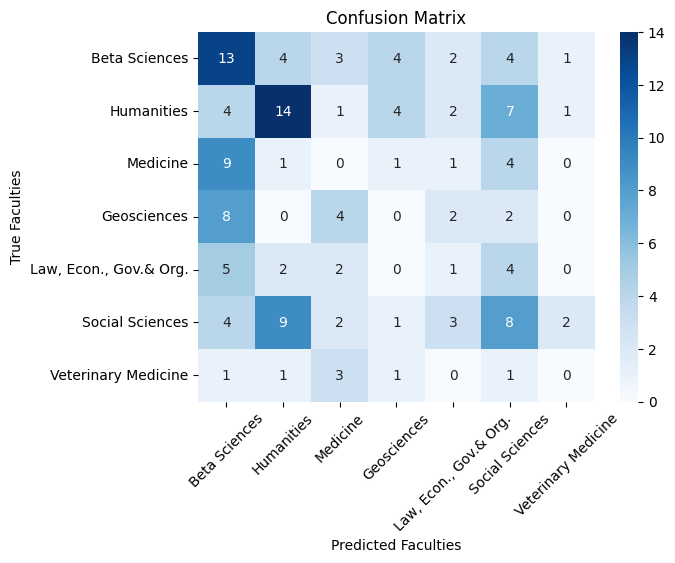

In [ ]:
#Get results of best scoring parameters and create confusion matrix
knn_grid_search.fit(X_train, y_train)

print('K-Nearest Neighbors Test Weighted F1 score: {}'.format(knn_grid_search.score(X_test, y_test)))
print('K-Nearest Neighbors Best Params: {}'.format(knn_grid_search.best_params_))
y_pred = knn_grid_search.predict(X_test)
y_true = y_test
class_labels = ['Beta Sciences',
    'Humanities',
    'Medicine',
    'Geosciences',
    'Law, Econ., Gov.& Org.',
    'Social Sciences',
    'Veterinary Medicine']
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
ax.set_xlabel('Predicted Faculties')
ax.set_ylabel('True Faculties')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

XGBoost Test Weighted F1 score: 0.3146561999644191
XGBoost Best Params: {'XGB__learning_rate': 0.3, 'XGB__max_depth': 2, 'XGB__min_child_weight': 1, 'XGB__n_estimators': 100, 'XGB__subsample': 1.0}


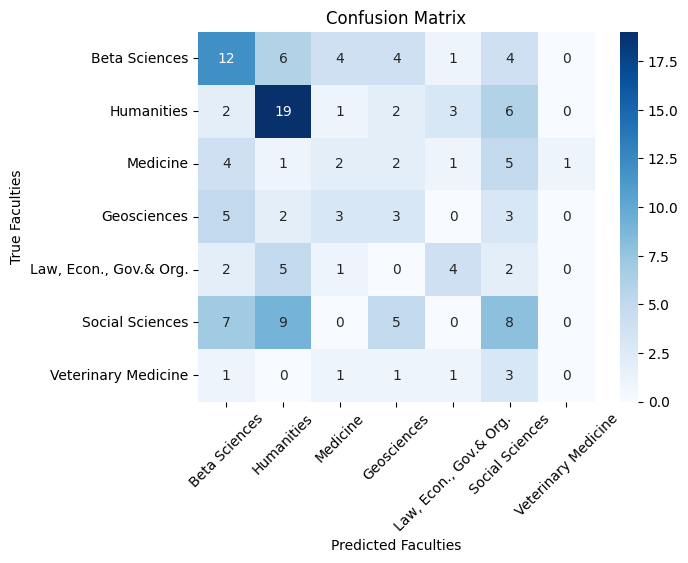

In [ ]:
#Get results of best scoring parameters and create confusion matrix
xgb_grid_search.fit(X_train, y_train)

print('XGBoost Test Weighted F1 score: {}'.format(xgb_grid_search.score(X_test, y_test)))
print('XGBoost Best Params: {}'.format(xgb_grid_search.best_params_))
y_pred = xgb_grid_search.predict(X_test)
y_true = y_test
class_labels = ['Beta Sciences',
    'Humanities',
    'Medicine',
    'Geosciences',
    'Law, Econ., Gov.& Org.',
    'Social Sciences',
    'Veterinary Medicine']
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
ax.set_xlabel('Predicted Faculties')
ax.set_ylabel('True Faculties')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()



Support Vector Machines Test Weighted F1 score: 0.3231787772966185
Support Vector Machines Best Params: {'SVM__C': 5, 'SVM__kernel': 'linear'}


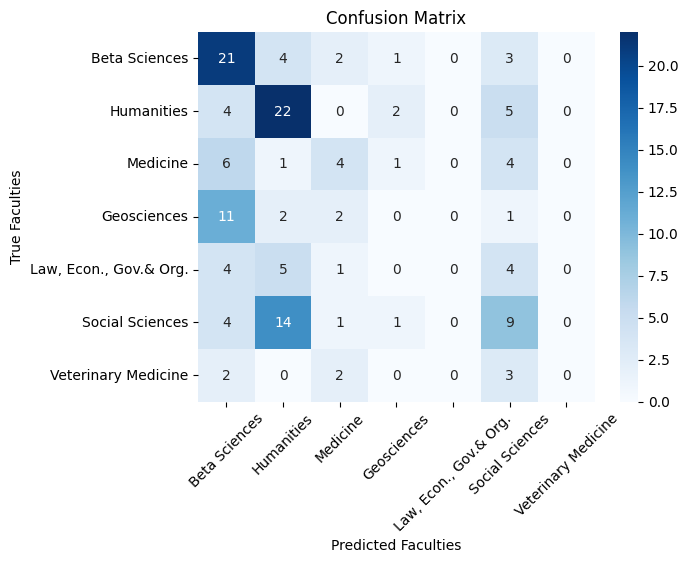

In [ ]:
#Get results of best scoring parameters and create confusion matrix
svm_grid_search.fit(X_train, y_train)

print('Support Vector Machines Test Weighted F1 score: {}'.format(svm_grid_search.score(X_test, y_test)))
print('Support Vector Machines Best Params: {}'.format(svm_grid_search.best_params_))
y_pred = svm_grid_search.predict(X_test)
y_true = y_test
class_labels = ['Beta Sciences',
    'Humanities',
    'Medicine',
    'Geosciences',
    'Law, Econ., Gov.& Org.',
    'Social Sciences',
    'Veterinary Medicine']
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
ax.set_xlabel('Predicted Faculties')
ax.set_ylabel('True Faculties')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()